# Maximum Covariance Analysis example
### (Or, 'NADA another Jupyter notebook!')
This notebook demonstrates how to apply [Maximum Covariance Analysis](https://doi.org/10.1175/1520-0442(1992)005<0541:AIOMFF>2.0.CO;2) ([MCA](https://en.wikipedia.org/wiki/Adam_Yauch)) to two different space-time data fields.  Here, we use the [North American Drought Atlas (NADA)](https://doi.org/10.1126/science.1102586) and the [Monsoon Asia Drought Atlas (MADA](https://doi.org/10.1126/science.1185188) to examine coupled, covarying patterns of drought in North America and Asia over the last 700 years.  Our hypothesis is that these should be linked at multiple timescales to sea surface temperature variability and associated ocean-atmosphere coupling in the Pacific.  Both dataset are independent and share no tree-ring data.  However, both also have their own errors and uncertainties and the individual drought atlases reflect a host of processes controlling droughts across multiple space- and time-scales. 

Let's read in our packages:

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt

# nicely render figures in the notebook 
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Cartopy gives a lot of warnings when downloading map data, which we'll suppress
import warnings
warnings.filterwarnings("ignore") 

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
plt.rcParams['font.family'] = 'Helvetica'

# import cartopy 
import cartopy # base Cartopy
import cartopy.crs as ccrs # shortcut to the coordinate reference system
import cartopy.feature as cfeature # add map features


We'll read in the low-resolution version of the NADA (v2) from 2008.  The time dimension will appear as a float64 type (not a datetime type) covering the last 2000 years.  If you're interested in why we aren't using Pandas and Xarray's full datetime functionality, see [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timestamp-limitations).

In [2]:
nada = xr.open_dataset('nadav2a2008.nc',decode_times=False)
nada = nada.reindex(time=nada.time[::-1]) # why? make time go forward (oldest to most recent) - probably an artefact from the netcdf build
nada = nada["PDSI"]
nada


<xarray.DataArray 'PDSI' (time: 2007, lat: 19, lon: 33)>
[1258389 values with dtype=float32]
Coordinates:
  * time     (time) int32 0 1 2 3 4 5 6 7 ... 2000 2001 2002 2003 2004 2005 2006
  * lat      (lat) float32 62.5 60.0 57.5 55.0 52.5 ... 27.5 25.0 22.5 20.0 17.5
  * lon      (lon) float32 -137.5 -135.0 -132.5 -130.0 ... -62.5 -60.0 -57.5
Attributes:
    long_name:   Palmer Drought Severity Index, Jun-Aug
    short_name:  PDSI_JJA

Now we'll read in the MADA (v1, as published in 2010), which only goes back to 1300.  Again, the time dimension will be read as a float64 type, not a datetime type. 

In [3]:
mada = xr.open_dataset('madav1.nc',decode_times=False)
mada = mada.reindex(time=mada.time[::-1]) # make time go forward - probably an artefact from the netcdf build
mada = mada["PDSI"]
mada

<xarray.DataArray 'PDSI' (time: 706, lat: 27, lon: 34)>
[648108 values with dtype=float32]
Coordinates:
  * time     (time) int32 1300 1301 1302 1303 1304 ... 2001 2002 2003 2004 2005
  * lat      (lat) float32 56.25 53.75 51.25 48.75 ... -1.25 -3.75 -6.25 -8.75
  * lon      (lon) float32 143.8 141.2 138.8 136.2 ... 68.75 66.25 63.75 61.25
Attributes:
    long_name:   Palmer Drought Severity Index, Jun-Aug
    short_name:  PDSI_JJA

Let's clip both NADA and MADA to a common period.  Since v1 of MADA only went back to 1300 that sets our early limit. 

In [4]:
# clip to a common time
start_year = 1300
end_year = 2005

nada = nada.sel(time=slice(start_year, end_year))
mada = mada.sel(time=slice(start_year, end_year))

In order to do simple matrix operations on our data, let's pull it out of the xarray DataArrays in to numpy arrays.  We'll then go through the process of reshaping from 3-dimensions to 2-dimensions, locating the complete grid points over the selected time period, and then z-scoring the columns:

In [5]:
N2d = nada.to_numpy()
M2d = mada.to_numpy()

ntime, nrow, ncol = N2d.shape
mtime, mrow, mcol = M2d.shape

N2d = np.reshape(N2d, (ntime, nrow*ncol), order='F') # 606 rows by 627 columns
M2d = np.reshape(M2d, (mtime, mrow*mcol), order='F') # 606 rows by 918 columns

N_complete = ~np.isnan(N2d).any(axis=0)
M_complete = ~np.isnan(M2d).any(axis=0)

# create a new array with only the columns of sst2d that are not missing any data 
N2d_complete = N2d[:, N_complete]
M2d_complete = M2d[:, M_complete]

N2d_complete = sp.stats.zscore(N2d_complete,axis=0)
M2d_complete = sp.stats.zscore(M2d_complete,axis=0)


We can now calculate our cross-covariance matrix using matrix operations.  If we wanted to apply any additional weighting, we would do that here as well:

In [6]:
C = (N2d_complete.T @ M2d_complete)/(ntime-1) # 251 by 510
C.shape


(211, 504)

We now run the SVD on our (non-square, non-symmetric) cross-covariance matrix.  Remember that U and V will no longer be the same size, and each will be associate with the data from one of the fields.  In the example below, U will be the eigenvectors associated with NADA, V with MADA.

In [7]:
U, L, V = sp.sparse.linalg.svds(C, k=3) # U will be the eigenvectors associated with NADA, V.T with MADA

# recall that sp.sparse.linalg.svds doesn't return modes in order, so we have to sort based on L
sort_index = np.argsort(L)[::-1] # sort L in descending order from high to low to rank the modes
S = L[sort_index] # apply the index
U = U[:,sort_index] # apply the index
V = V[sort_index,:] # apply the index


We can now get the PCs - we use matrix operations and project the respective eigenvectors back on the z-scores data matrices associated with each mode:

In [8]:
Npc = N2d_complete @ U  # project U onto the NADA data
Mpc = M2d_complete @ V.T # project V onto the MADA data

# scf = (L ** 2) / np.sum(L ** 2) # we could do this if we were using a full SVD, but here this won't work


Let's put our PCs in a DataArray so we can use `xr.corr`:

In [9]:
npc_array = xr.DataArray(Npc, coords={'time': nada.time, 'mode': np.arange(0,3)}, dims=["time","mode"],name="npc")
mpc_array = xr.DataArray(Mpc, coords={'time': mada.time, 'mode': np.arange(0,3)}, dims=["time","mode"],name="mpc")


We are going to calculate what are called the homogeneous and heterogeneous correlations - the homogeneous correlations are the correlations between the PCs and the original data field from whence they came, while heterogeneous correlations are the correlation between the PCs and the other data field. 

In [10]:

nada_homogenous_correlation = xr.corr(npc_array,nada,dim="time")
mada_homogenous_correlation = xr.corr(mpc_array,mada,dim="time")

nada_heterogeneous_correlation = xr.corr(npc_array,mada,dim="time")
mada_heterogeneous_correlation = xr.corr(mpc_array,nada,dim="time")


Let's plot the Homogeneous Correlations first:

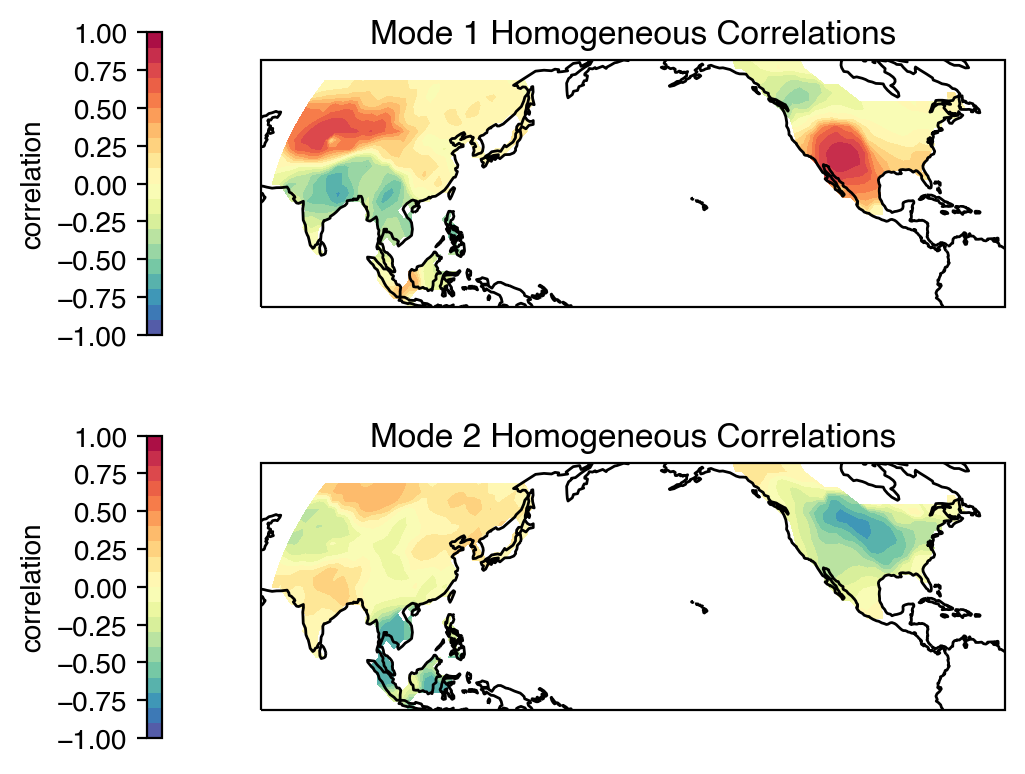

In [11]:
# plot the Homogeneous correlation field
fig, (ax1,ax2) = plt.subplots(clear=True,nrows=2,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 21)

nox1 = ax1.contourf(nada.lon,nada.lat,nada_homogenous_correlation[0,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
mox1 = ax1.contourf(mada.lon,mada.lat,mada_homogenous_correlation[0,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
# ax1.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax1.coastlines()  # we can pass arguments to .coastlines function
# ax1.add_feature(cfeature.LAND, color='black')
ax1.set_title('Mode 1 Homogeneous Correlations', fontsize=12)
cb1 = plt.colorbar(nox1, orientation='vertical',location='left',shrink=0.9,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb1.set_label('correlation', fontsize=10) 

nox2 = ax2.contourf(nada.lon,nada.lat,nada_homogenous_correlation[1,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
mox2 = ax2.contourf(mada.lon,mada.lat,mada_homogenous_correlation[1,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())

# ax2.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax2.coastlines()  # we can pass arguments to .coastlines function
# ax2.add_feature(cfeature.LAND, color='black')
ax2.set_title('Mode 2 Homogeneous Correlations', fontsize=12)
cb2 = plt.colorbar(nox2, orientation='vertical',location='left',shrink=0.9,extend='both',ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb2.set_label('correlation', fontsize=10) 

And now let's look at the heterogeneous correlation fields:

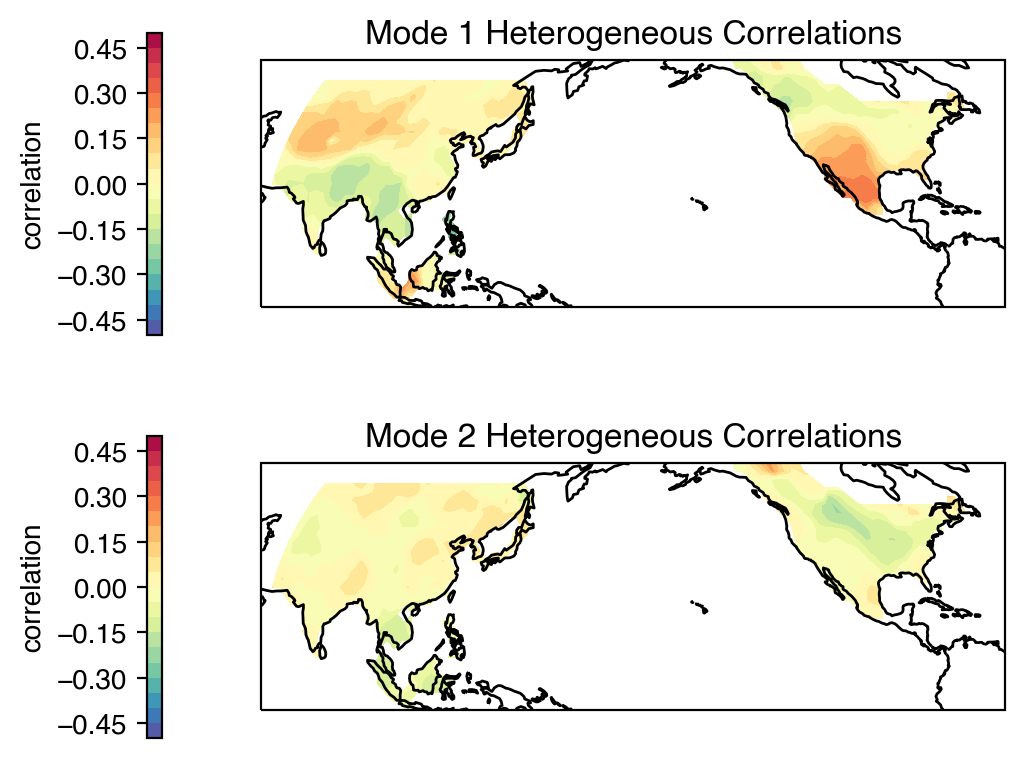

In [12]:
# plot the Heterogeneous correlations
fig, (ax1,ax2) = plt.subplots(clear=True,nrows=2,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the map
levels = np.linspace(-0.5, 0.5, 21)

nox1 = ax1.contourf(mada.lon,mada.lat,nada_heterogeneous_correlation[0,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, vmin=-0.5,vmax=0.5,transform=ccrs.PlateCarree())
mox1 = ax1.contourf(nada.lon,nada.lat,mada_heterogeneous_correlation[0,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, vmin=-0.5,vmax=0.5,transform=ccrs.PlateCarree())
# ax1.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax1.coastlines()  # we can pass arguments to .coastlines function
# ax1.add_feature(cfeature.LAND, color='black')
ax1.set_title('Mode 1 Heterogeneous Correlations', fontsize=12)
cb1 = plt.colorbar(nox1, orientation='vertical',location='left',shrink=0.9,extend='both') #,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb1.set_label('correlation', fontsize=10) 

nox2 = ax2.contourf(mada.lon,mada.lat,nada_heterogeneous_correlation[1,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, vmin=-0.5,vmax=0.5,transform=ccrs.PlateCarree())
mox2 = ax2.contourf(nada.lon,nada.lat,mada_heterogeneous_correlation[1,:,:],levels=levels, cmap='Spectral_r',add_colorbar=False, vmin=-0.5,vmax=0.5,transform=ccrs.PlateCarree())

# ax2.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax2.coastlines()  # we can pass arguments to .coastlines function
# ax2.add_feature(cfeature.LAND, color='black')
ax2.set_title('Mode 2 Heterogeneous Correlations', fontsize=12)
cb2 = plt.colorbar(nox2, orientation='vertical',location='left',shrink=0.9,extend='both') #,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb2.set_label('correlation', fontsize=10) 

In order to take advantage of xarray for doing rolling correlations, let's put both out PC DataArrays in the same DataSet

In [13]:
both_pcs = xr.merge([npc_array,mpc_array])
both_pcs

<xarray.Dataset>
Dimensions:  (time: 706, mode: 3)
Coordinates:
  * time     (time) int32 1300 1301 1302 1303 1304 ... 2001 2002 2003 2004 2005
  * mode     (mode) int64 0 1 2
Data variables:
    npc      (time, mode) float32 -2.377 -1.946 -2.776 ... 2.01 -3.071 0.8007
    mpc      (time, mode) float32 -4.889 -2.354 -0.3113 ... 4.79 7.874 24.02

We can then use a `rolling` object from xarray to build overlapping windows of a certain time dimension:

In [14]:
rolling = both_pcs.rolling(time=50,center=True) # create a rolling object: https://docs.xarray.dev/en/stable/generated/xarray.DataArray.rolling.html
windowed = rolling.construct('window') # see: https://docs.xarray.dev/en/stable/generated/xarray.core.rolling.DataArrayRolling.construct.html
windowed # note that we now see the data from our initial dataset in this new Dataset, but now with a new dimension of the rolling50 year  windows

<xarray.Dataset>
Dimensions:  (time: 706, mode: 3, window: 50)
Coordinates:
  * time     (time) int32 1300 1301 1302 1303 1304 ... 2001 2002 2003 2004 2005
  * mode     (mode) int64 0 1 2
Dimensions without coordinates: window
Data variables:
    npc      (time, mode, window) float32 nan nan nan nan ... nan nan nan nan
    mpc      (time, mode, window) float32 nan nan nan nan ... nan nan nan nan

With the new dimension, which is the 50 year windows, we can call `xr.corr`` and do a moving (rolling) correlation (see more [here](https://stackoverflow.com/questions/45311849/rolling-correlation-coefficients-for-two-xarray-dataarrays)) - we know that our leading PCs vary significantly (although relatively weakly) with each over the 700 years, but is that relationship stable? 

In [15]:
# this returns the overall correlation between the leading PCs 
overall_correlation = xr.corr(both_pcs['npc'].sel(mode=0),both_pcs['mpc'].sel(mode=0), dim='time')

# rolling correlation - specify the first mode from each variable and the dimension here is the window we added above
rolling_correlation = xr.corr(windowed['npc'].sel(mode=0),windowed['mpc'].sel(mode=0), dim='window')
rolling_correlation # 706 years of correlation values calculated over 50 year windows - this is odd behavior
rolling_correlation


<xarray.DataArray (time: 706)>
array([ 0.46040734,  0.4563327 ,  0.45461277,  0.39430108,  0.37592367,
        0.35464444,  0.36346293,  0.35177974,  0.34431587,  0.32787702,
        0.32887483,  0.31153322,  0.33866874,  0.34363173,  0.28378506,
        0.28833995,  0.2954641 ,  0.29600264,  0.28625499,  0.28021384,
        0.2719619 ,  0.27510417,  0.28848781,  0.25239099,  0.28012847,
        0.28069227,  0.24428479,  0.23468616,  0.22487091,  0.22958238,
        0.23076985,  0.23430606,  0.17920037,  0.20813528,  0.19901973,
        0.20422726,  0.21196511,  0.20168198,  0.18453375,  0.14971881,
        0.05807007,  0.04690578, -0.02787106,  0.00965496,  0.07119395,
        0.08191499,  0.0369115 ,  0.04428914,  0.03139199, -0.00784041,
       -0.02462102,  0.07693341,  0.12739529,  0.15321534,  0.14992323,
        0.1808559 ,  0.15229891,  0.15684431,  0.17827914,  0.14225296,
        0.13244209,  0.1604725 ,  0.13769615,  0.1240506 ,  0.1553546 ,
        0.16754967,  0.20790465,  0.20045132,  0.21333165,  0.21975676,
        0.24671623,  0.22860202,  0.20491335,  0.23523926,  0.21653574,
        0.25730813,  0.2867643 ,  0.28740586,  0.28328511,  0.26777501,
        0.30351643,  0.3048265 ,  0.35231415,  0.35419575,  0.3473152 ,
        0.34405487,  0.37156848,  0.36528061,  0.39305759,  0.44672462,
        0.43757225,  0.43863294,  0.41799413,  0.42800019,  0.38620011,
        0.3696988 ,  0.38185214,  0.36061412,  0.38260606,  0.35097871,
...
        0.50414237,  0.508193  ,  0.50775447,  0.51944199,  0.51912902,
        0.50656352,  0.5017143 ,  0.48516575,  0.48679819,  0.46434678,
        0.43063436,  0.43500723,  0.47033177,  0.47101658,  0.47762844,
        0.4624538 ,  0.51385115,  0.51956875,  0.47808033,  0.45290872,
        0.44007291,  0.43624978,  0.47001112,  0.45345246,  0.45292134,
        0.41506118,  0.40823427,  0.40670369,  0.40558289,  0.40364028,
        0.3509783 ,  0.34869749,  0.33706936,  0.34991883,  0.33178593,
        0.32667886,  0.26849753,  0.29397236,  0.26701214,  0.28717159,
        0.30727457,  0.27478102,  0.28689731,  0.28859002,  0.29710733,
        0.35004652,  0.3418024 ,  0.30931036,  0.32398167,  0.35125696,
        0.37819718,  0.35908057,  0.35753139,  0.38346958,  0.3783029 ,
        0.37573482,  0.38405387,  0.39406461,  0.4388862 ,  0.45434426,
        0.48509838,  0.49436306,  0.49131335,  0.4970491 ,  0.50403303,
        0.51057338,  0.53024835,  0.53304574,  0.51709643,  0.52414434,
        0.5613838 ,  0.56590698,  0.54273194,  0.54635889,  0.51639066,
        0.55892482,  0.56378427,  0.56531501,  0.56982216,  0.57497939,
        0.62361294,  0.64409029,  0.64934283,  0.6487461 ,  0.66985745,
        0.67216182,  0.69515387,  0.68116921,  0.7226336 ,  0.71443205,
        0.69570078,  0.72532392,  0.73062234,  0.72915492,  0.72952291,
        0.70701558])
Coordinates:
  * time     (time) int32 1300 1301 1302 1303 1304 ... 2001 2002 2003 2004 2005
    mode     int64 0

Let's plot the rolling correlation as well as indicate the overall 700-year correlation:

Text(0.5, 1.0, 'LEADING DROUGHT MODES MOVING (50 YEAR) CORRELATION')

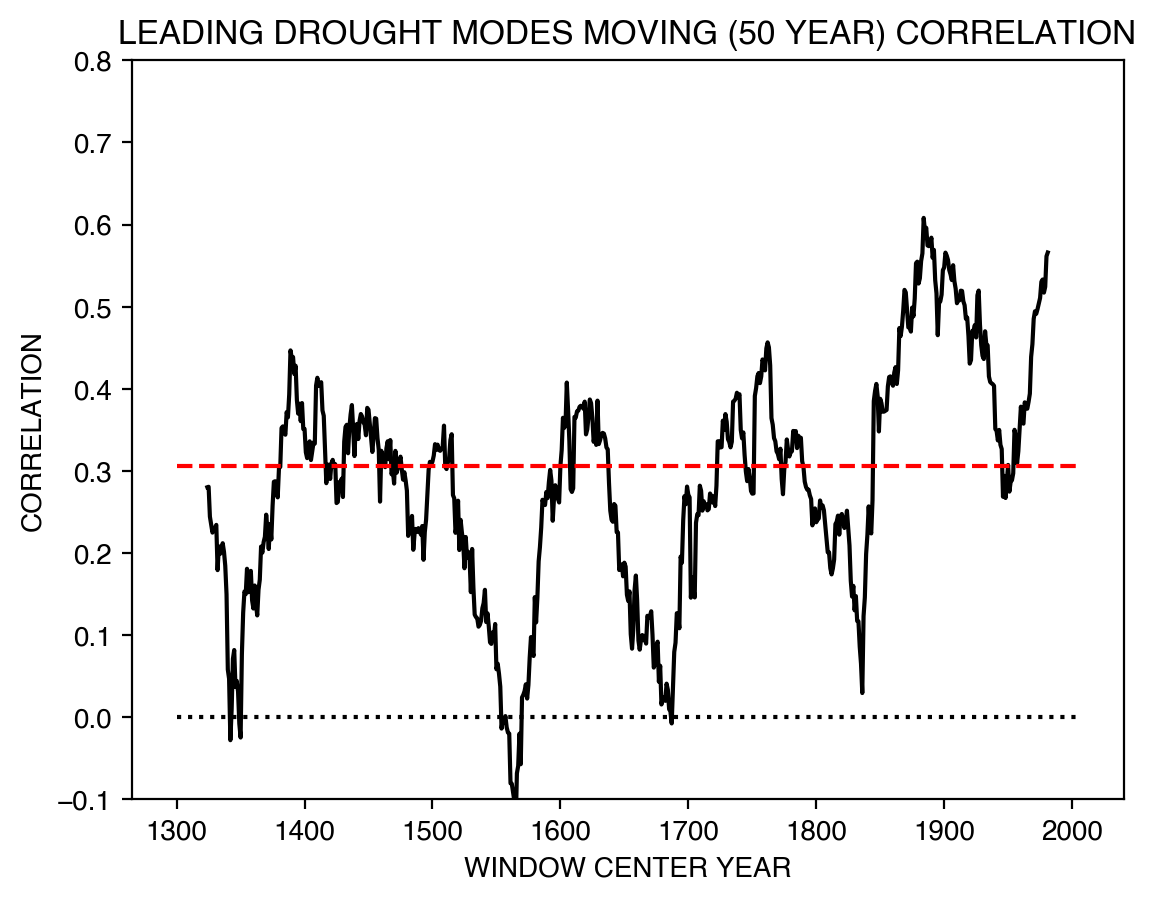

In [16]:
plt.plot(rolling_correlation.time.values[24:-24],rolling_correlation[24:-24],color="black")
plt.ylim([-0.1,0.8])
plt.plot([1300,2005],[overall_correlation,overall_correlation],'r--')
plt.plot([1300,2005],[0,0],'k:')
plt.xlabel('WINDOW CENTER YEAR')
plt.ylabel('CORRELATION')
plt.title('LEADING DROUGHT MODES MOVING (50 YEAR) CORRELATION')

We can see that the relation waxes and wanes over time!  This might prove a fruitful line of inquiry about the causes of this and what it reveals about the link between drought and larger-scale ocean-atmosphere variability, keeping in mind the caveats and uncertainties in both our data and statistical methods.

One such avenue of investigation might be to see if indeed these coupled drought patterns are linked to SSTs in the Pacific.  Let's bring in our SST data and make a DJF average (to highlight peak ENSO conditions):

In [17]:
sst= xr.open_dataset("HadISST_sst.nc",mask_and_scale=True)["sst"] # read in the SST dataset and extract sst only as a DataArray
# sst["time"] = sst["time"].dt.strftime("%Y").astype(int) # ensure that the time dimensions have the same format - is there a better way? 

# turn negative SST values in NaN
sst = sst.where(sst >= 0, np.nan)

# change the longitudes from -180,180 to 0,360
sst = sst.assign_coords(longitude=(sst.longitude % 360))

# now, sort the coordinates and associated data so they are in the correct order from 0 to 360
sst = sst.sortby(sst.longitude)

# Calculate the 5-month rolling mean, skipping NaN values
season_length = 5
end_month = 3

sst_ = sst.rolling(time=season_length).mean(skipna=True)
sst_winter = sst_[sst_.time.dt.month == end_month]
sst_winter = sst_winter.drop_isel(time=0)
sst_winter["time"] = sst_winter["time"].dt.strftime("%Y").astype(int) 
sst_winter



<xarray.DataArray 'sst' (time: 153, latitude: 180, longitude: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time       (time) int64 1871 1872 1873 1874 1875 ... 2020 2021 2022 2023
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

We can do do a field correlation between the overlapping parts of our PCs and the SST data:

In [18]:
field_correlation_nada = xr.corr(npc_array[:,0],sst_winter,dim="time")
field_correlation_mada = xr.corr(mpc_array[:,0],sst_winter,dim="time")

Let's plot the field correlations:

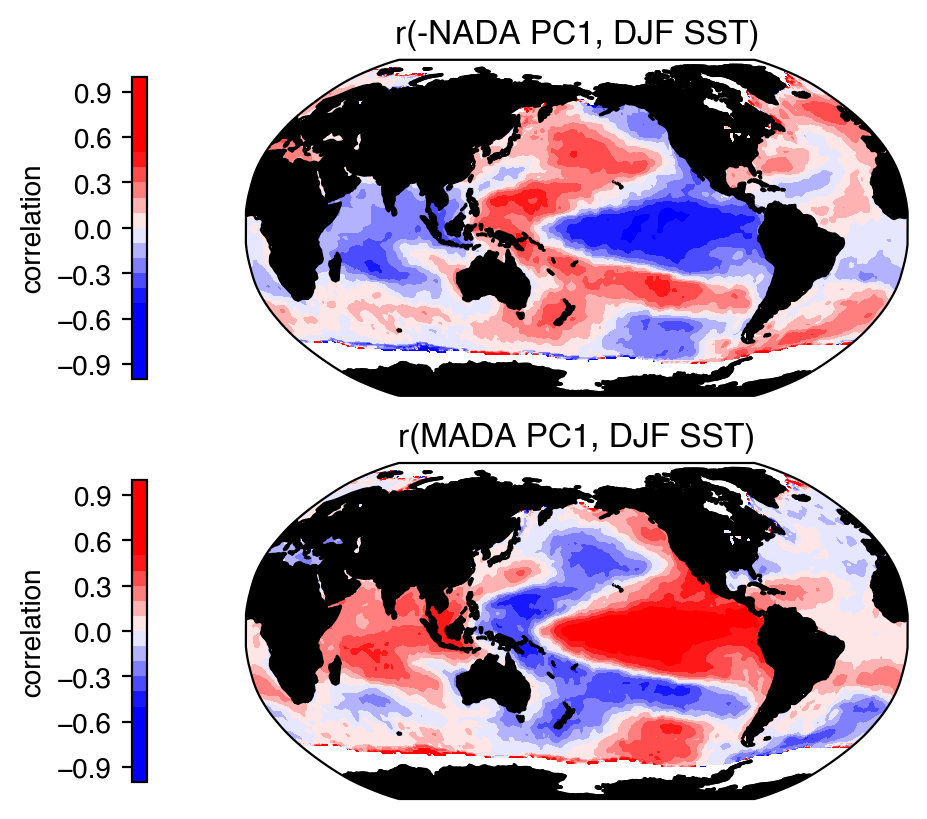

In [19]:
# plot the field correlations
fig, (ax1,ax2) = plt.subplots(clear=True,nrows=2,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 21)

nox1 = ax1.contourf(sst_winter.longitude,sst_winter.latitude,-field_correlation_nada,levels=levels, cmap='bwr',add_colorbar=False, vmin=-0.5,vmax=0.5,transform=ccrs.PlateCarree())
ax1.coastlines()  # we can pass arguments to .coastlines function
ax1.add_feature(cfeature.LAND, color='black')
ax1.set_title('r(-NADA PC1, DJF SST)', fontsize=12)
cb1 = plt.colorbar(nox1, orientation='vertical',location='left',shrink=0.9,extend='both') #,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb1.set_label('correlation', fontsize=10) 

nox1 = ax2.contourf(sst_winter.longitude,sst_winter.latitude,field_correlation_mada,levels=levels, cmap='bwr',add_colorbar=False, vmin=-0.5,vmax=0.5,transform=ccrs.PlateCarree())
ax2.coastlines()  # we can pass arguments to .coastlines function
ax2.add_feature(cfeature.LAND, color='black')
ax2.set_title('r(MADA PC1, DJF SST)', fontsize=12)
cb2 = plt.colorbar(nox1, orientation='vertical',location='left',shrink=0.9,extend='both') #,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb2.set_label('correlation', fontsize=10) 



We can do this for the second mode as well:

In [20]:
field_correlation_nada = xr.corr(npc_array[:,1],sst_winter,dim="time")
field_correlation_mada = xr.corr(mpc_array[:,1],sst_winter,dim="time")

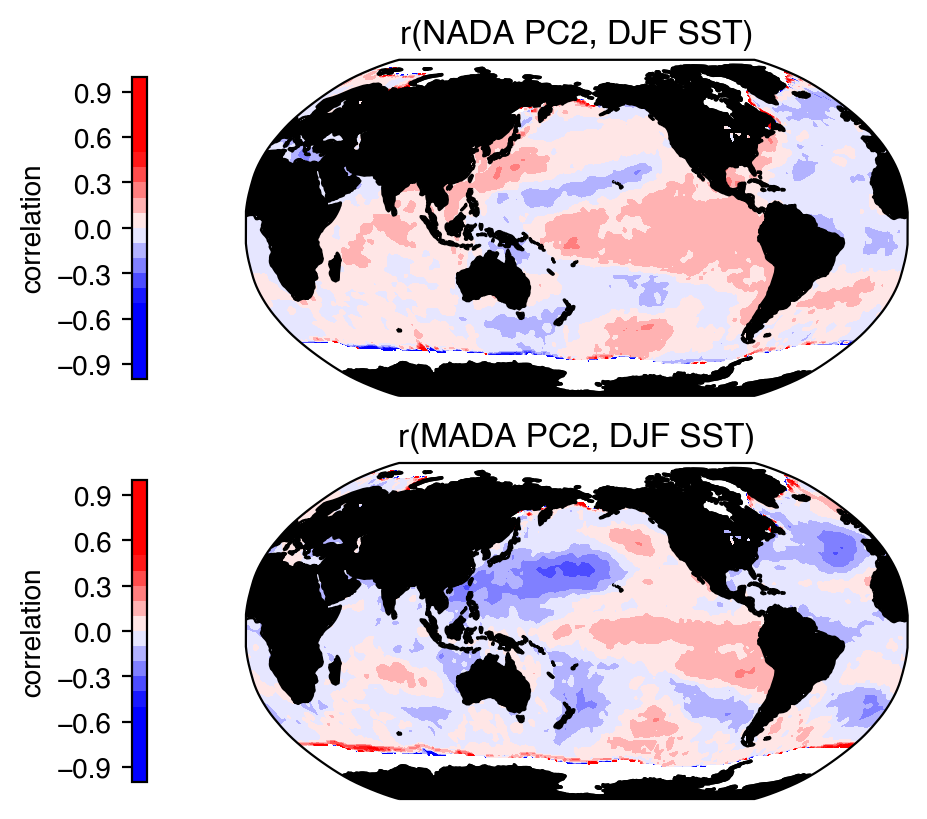

In [21]:
# plot the Heterogeneous correlations
fig, (ax1,ax2) = plt.subplots(clear=True,nrows=2,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 21)

nox1 = ax1.contourf(sst_winter.longitude,sst_winter.latitude,-field_correlation_nada,levels=levels, cmap='bwr',add_colorbar=False, vmin=-0.5,vmax=0.5,transform=ccrs.PlateCarree())
ax1.coastlines()  # we can pass arguments to .coastlines function
ax1.add_feature(cfeature.LAND, color='black')
ax1.set_title('r(NADA PC2, DJF SST)', fontsize=12)
cb1 = plt.colorbar(nox1, orientation='vertical',location='left',shrink=0.9,extend='both') #,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb1.set_label('correlation', fontsize=10) 

nox1 = ax2.contourf(sst_winter.longitude,sst_winter.latitude,field_correlation_mada,levels=levels, cmap='bwr',add_colorbar=False, vmin=-0.5,vmax=0.5,transform=ccrs.PlateCarree())
ax2.coastlines()  # we can pass arguments to .coastlines function
ax2.add_feature(cfeature.LAND, color='black')
ax2.set_title('r(MADA PC2, DJF SST)', fontsize=12)
cb2 = plt.colorbar(nox1, orientation='vertical',location='left',shrink=0.9,extend='both') #,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb2.set_label('correlation', fontsize=10) 
